In [35]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.exceptions import OptimizationError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
import requests
warnings.filterwarnings('ignore')

In [73]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

response = requests.get(url, headers=headers)

response.raise_for_status()

sp500 = pd.read_html(response.text)[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')


symbol_list = sp500['Symbol'].unique().tolist()


end_date = '2025-10-09'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=15)
symbol_list = ['NVDA','SPY','AAPL','TSLA']
df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


vix_data = web.DataReader("VIXCLS", "fred", start_date, end_date)
vix_data.index.names = ['date']
vix_data.rename(columns={'VIXCLS':'vix'}, inplace=True)
df = df.join(vix_data, how='left')

# Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2
)

# RSI
df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: ta.rsi(x, length=20))

#df['rsi_state'] = np.select(
#    [df['rsi'] < 30, df['rsi'] > 70],
#    [-1, 1],
#    default=0
#)


# Bollinger Bands
def compute_bb(group, key):
 # log_close = np.log1p(group['adj close'])
 # bb = ta.bbands(close=log_close, length=20)
  bb = ta.bbands(close=group['adj close'], length=20)
  return bb.iloc[:,key]

df['bb_low'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 0)
df['bb_mid'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 1)
df['bb_high'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 2)

df['bb_position'] = ((df['adj close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']))



# ATR
def compute_atr(group):
    atr = ta.atr(group['high'], group['low'], group['close'], length=14)
    #return (atr - atr.mean()) / atr.std()
    return atr

df['atr'] = df.groupby('ticker', group_keys=False).apply(compute_atr)


# MACD
def compute_macd(group):
    macd_line = ta.macd(group, length=20).iloc[:, 0]
    #return (macd_line - macd_line.mean()) / macd_line.std()
    return macd_line

df['macd'] = df.groupby('ticker')['adj close'].transform(compute_macd)


# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df

[*********************100%***********************]  4 of 4 completed


adj close       close        high         low        open  \
date       ticker                                                               
2010-10-11 AAPL      8.866742   10.548571   10.615714   10.521429   10.526429   
           NVDA      0.247788    0.270250    0.275000    0.269000    0.272750   
           SPY      89.032356  116.650002  116.970001  116.250000  116.720001   
           TSLA      1.349333    1.349333    1.380000    1.338000    1.362667   
2010-10-12 AAPL      8.962204   10.662143   10.696429   10.446071   10.550357   
...                       ...         ...         ...         ...         ...   
2025-10-07 TSLA    433.089996  433.089996  452.679993  432.450012  447.820007   
2025-10-08 AAPL    258.059998  258.059998  258.519989  256.109985  256.519989   
           NVDA    189.110001  189.110001  189.600006  186.539993  186.570007   
           SPY     673.109985  673.109985  673.210022  669.419983  670.250000   
           TSLA    438.690002  438.690002  441.329987  425.230011  437.570007   

                      volume    vix  garman_klass_vol         rsi      bb_low  \
date       ticker                                                               
2010-10-11 AAPL    427753200  18.96         -0.011333         NaN         NaN   
           NVDA    442680000  18.96         -0.003315         NaN         NaN   
           SPY     103098300  18.96         -0.028304         NaN         NaN   
           TSLA      2568000  18.96          0.000440         NaN         NaN   
2010-10-12 AAPL    558544000  18.93         -0.010001  100.000000         NaN   
...                      ...    ...               ...         ...         ...   
2025-10-07 TSLA    102296100  17.24          0.000613   59.327659  370.053357   
2025-10-08 AAPL     36496900  16.30          0.000030   68.158493  230.301239   
           NVDA    130168900  16.30          0.000062   61.575240  170.053063   
           SPY      60702200  16.30          0.000009   68.699782  652.799291   
           TSLA     71192100  16.30          0.000688   60.399174  387.968677   

                       bb_mid     bb_high  bb_position        atr       macd  \
date       ticker                                                              
2010-10-11 AAPL           NaN         NaN          NaN        NaN        NaN   
           NVDA           NaN         NaN          NaN        NaN        NaN   
           SPY            NaN         NaN          NaN        NaN        NaN   
           TSLA           NaN         NaN          NaN        NaN        NaN   
2010-10-12 AAPL           NaN         NaN          NaN        NaN        NaN   
...                       ...         ...          ...        ...        ...   
2025-10-07 TSLA    423.959000  477.864642     0.584694  18.936898  22.512231   
2025-10-08 AAPL    249.367999  268.434760     0.727936   4.302038   6.812987   
           NVDA    180.879000  191.704937     0.880152   5.100607   3.279624   
           SPY     663.587436  674.375580     0.941343   4.805865   6.607703   
           TSLA    428.503999  469.039322     0.625644  18.734261  21.250543   

                   dollar_volume  
date       ticker                 
2010-10-11 AAPL      3792.777321  
           NVDA       109.690896  
           SPY       9179.084576  
           TSLA         3.465087  
2010-10-12 AAPL      5005.785260  
...                          ...  
2025-10-07 TSLA     44303.417574  
2025-10-08 AAPL      9418.389925  
           NVDA     24616.240758  
           SPY      40859.256953  
           TSLA     31231.262523  

[15088 rows x 16 columns]

Change Between Monthly and Weekly:

In [74]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

                                                            # Change Here
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('W').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('W').last().stack('ticker')],
                  axis=1)).dropna()           # Change Here

data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank'] < 150].drop(columns=['dollar_vol_rank'],axis=1)


def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
      df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))

    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()

def add_forward_returns(data, months_forward=1):
    data = data.copy()

    # Group by ticker and calculate forward return
    data[f'fwd_return_{months_forward}m'] = (
        data.groupby('ticker')['adj close']
            .transform(lambda x: x.shift(-months_forward) / x - 1)
    )
    
    return data

data = data.groupby('ticker', group_keys=False).apply(add_forward_returns).dropna()

data

dollar_volume   adj close    vix  garman_klass_vol  \
date       ticker                                                       
2011-05-01 AAPL      4694.539430   10.510946  14.75         -0.010183   
           NVDA       462.182841    0.458443  14.75         -0.000959   
           SPY      15465.008668  105.131706  14.75         -0.025827   
           TSLA        39.535914    1.840000  14.75          0.000128   
2011-05-08 AAPL      4653.757861   10.406774  18.40         -0.012791   
...                          ...         ...    ...               ...   
2025-09-28 TSLA     29931.071505  440.399994  15.29          0.000720   
2025-10-05 AAPL     11880.269636  258.019989  16.65          0.000147   
           NVDA     32230.477714  187.619995  16.65          0.000325   
           SPY      36413.378015  669.210022  16.65          0.000022   
           TSLA     30455.429421  429.829987  16.65          0.002080   

                         rsi      bb_low      bb_mid     bb_high  bb_position  \
date       ticker                                                               
2011-05-01 AAPL    55.108986    9.753357   10.219313   10.685270     0.812940   
           NVDA    56.941758    0.383943    0.419739    0.455534     1.040628   
           SPY     65.290660  100.148483  102.637670  105.126857     1.000974   
           TSLA    60.493062    1.619798    1.744400    1.869002     0.883621   
2011-05-08 AAPL    52.075446    9.777055   10.274400   10.771745     0.633080   
...                      ...         ...         ...         ...          ...   
2025-09-28 TSLA    68.210490  302.803646  387.984000  473.164353     0.807677   
2025-10-05 AAPL    69.193551  224.464335  245.757499  267.050663     0.787944   
           NVDA    61.296191  167.200460  178.713045  190.225629     0.886835   
           SPY     68.016318  647.125675  660.194183  673.262692     0.844945   
           TSLA    60.986994  344.812854  414.310500  483.808146     0.611655   

                         atr       macd  return_1m  return_2m  return_3m  \
date       ticker                                                          
2011-05-01 AAPL     0.230018   0.050537  -0.001625   0.034036   0.014773   
           NVDA     0.019222   0.003410   0.079914   0.033899   0.044522   
           SPY      1.275400   0.887812   0.019809   0.016488   0.008878   
           TSLA     0.070000   0.049093   0.032161   0.038734   0.013777   
2011-05-08 AAPL     0.209107   0.051843  -0.009911  -0.005777   0.019174   
...                      ...        ...        ...        ...        ...   
2025-09-28 TSLA    16.381490  26.733279   0.033633   0.054651   0.078730   
2025-10-05 AAPL     4.685712   7.424016   0.010021   0.025182   0.033005   
           NVDA     5.214554   3.117429   0.052921   0.030524   0.018043   
           SPY      4.942972   6.536526   0.011166   0.004142   0.006876   
           TSLA    18.414629  24.323512  -0.024001   0.004403   0.027754   

                   return_6m  return_9m  return_12m  fwd_return_1m  
date       ticker                                                   
2011-05-01 AAPL     0.009576   0.000627    0.000869      -0.009911  
           NVDA     0.021341  -0.015978   -0.020584      -0.034000  
           SPY      0.011003   0.003879    0.003657      -0.016345  
           TSLA     0.031152   0.017501    0.013635      -0.017391  
2011-05-08 AAPL    -0.002327  -0.004187   -0.002411      -0.017770  
...                      ...        ...         ...            ...  
2025-09-28 TSLA     0.048977   0.037549    0.028224      -0.024001  
2025-10-05 AAPL     0.021008   0.027485    0.016938       0.000155  
           NVDA     0.008830   0.008596    0.010809       0.007942  
           SPY      0.006544   0.008522    0.006129       0.005828  
           TSLA     0.039842   0.039756    0.026645       0.020613  

[3016 rows x 18 columns]

Change Between Monthly and Weekly

In [75]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
                                # Change Here
factor_data = factor_data.resample('W').last().div(100)

factor_data.index.name = 'date'
factor_data = factor_data.ffill() # only use when doing weekly

factor_data = factor_data.join(data['return_1m']).sort_index()


observations = factor_data.groupby('ticker').size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]


betas = (factor_data.groupby('ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                      window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2011-05-01 AAPL         NaN       NaN       NaN       NaN       NaN
           NVDA         NaN       NaN       NaN       NaN       NaN
           SPY          NaN       NaN       NaN       NaN       NaN
           TSLA         NaN       NaN       NaN       NaN       NaN
2011-05-08 AAPL         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-07-27 TSLA    0.117640 -1.017493 -1.459766  0.534071  0.224090
2025-08-03 AAPL    0.731265 -0.958944  0.697996 -0.180911 -1.040800
           NVDA    0.569983  0.076842 -0.293238  0.014708 -0.122469
           SPY     0.226981 -0.168181 -0.151157  0.026672 -0.130073
           TSLA   -0.071246  0.091074 -1.442317  0.434699  0.418150

[2980 rows x 5 columns]

In [76]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift(1)))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop(['dollar_volume','bb_low', 'bb_mid', 'bb_high'], axis=1)

data = data.dropna()

Kalman Filter

In [77]:
lstm_data = data.xs('SPY', level='ticker')
lstm_data.drop(columns=['fwd_return_1m'],inplace=True)
lstm_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2011-05-01 to 2025-10-05
Freq: W-SUN
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         754 non-null    float64
 1   vix               754 non-null    float64
 2   garman_klass_vol  754 non-null    float64
 3   rsi               754 non-null    float64
 4   bb_position       754 non-null    float64
 5   atr               754 non-null    float64
 6   macd              754 non-null    float64
 7   return_1m         754 non-null    float64
 8   return_2m         754 non-null    float64
 9   return_3m         754 non-null    float64
 10  return_6m         754 non-null    float64
 11  return_9m         754 non-null    float64
 12  return_12m        754 non-null    float64
 13  Mkt-RF            754 non-null    float64
 14  SMB               754 non-null    float64
 15  HML               754 non-null    float64
 16  RMW          

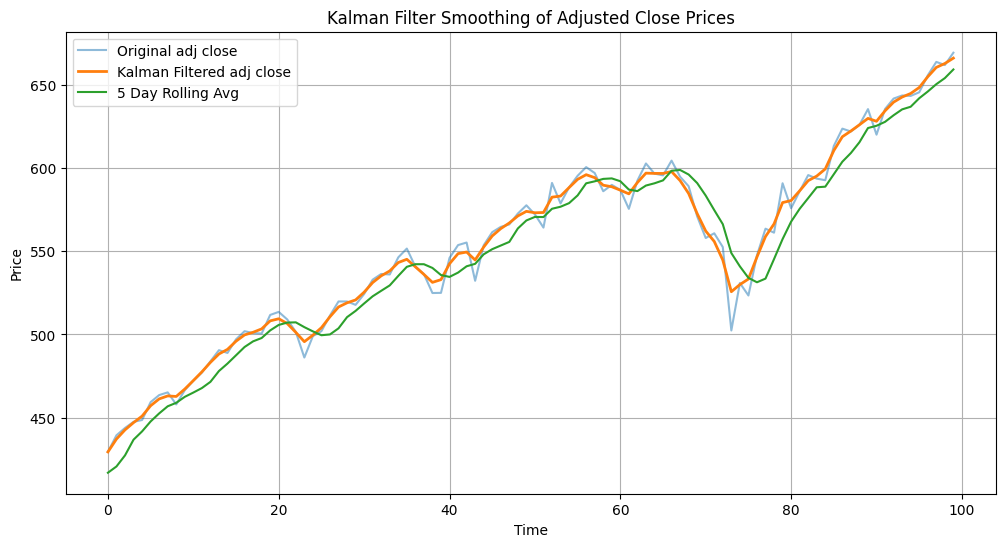

In [82]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Assume lstm_data is your DataFrame and 'adj close' is the column of interest
adj_close = lstm_data['adj close'].values

# Initialize Kalman Filter
kf = KalmanFilter(initial_state_mean=adj_close[0], n_dim_obs=1)

# Estimate the state with Kalman Filter (smoothing)
state_means, _ = kf.smooth(adj_close)
moving_avg = lstm_data['adj close'].rolling(window=5).mean().reset_index('date').drop(columns='date').dropna()['adj close'].to_list()

# Plot original vs Kalman filtered
plt.figure(figsize=(12, 6))
plt.plot(adj_close[-100:], label='Original adj close', alpha=0.5)
plt.plot(state_means[-100:], label='Kalman Filtered adj close', linewidth=2)
plt.plot(moving_avg[-100:], label='5 Day Rolling Avg')
plt.title('Kalman Filter Smoothing of Adjusted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2014 - mae: 0.3307 - val_loss: 8.3020 - val_mae: 2.8599 - learning_rate: 5.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1052 - mae: 0.2514 - val_loss: 8.1245 - val_mae: 2.8291 - learning_rate: 5.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0702 - mae: 0.2054 - val_loss: 7.8794 - val_mae: 2.7861 - learning_rate: 5.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0549 - mae: 0.1794 - val_loss: 7.6200 - val_mae: 2.7396 - learning_rate: 5.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0509 - mae: 0.1740 - val_loss: 7.2510 - val_mae: 2.6729 - learning_rate: 5.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0423 - mae: 0.1606 - val_loss: 6.6042 - val_mae: 2.5501 - learning_rate: 5.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0509 - mae: 0.1749 - val_loss: 5.8003 - val_mae: 2.3898 - learning_rate: 5.

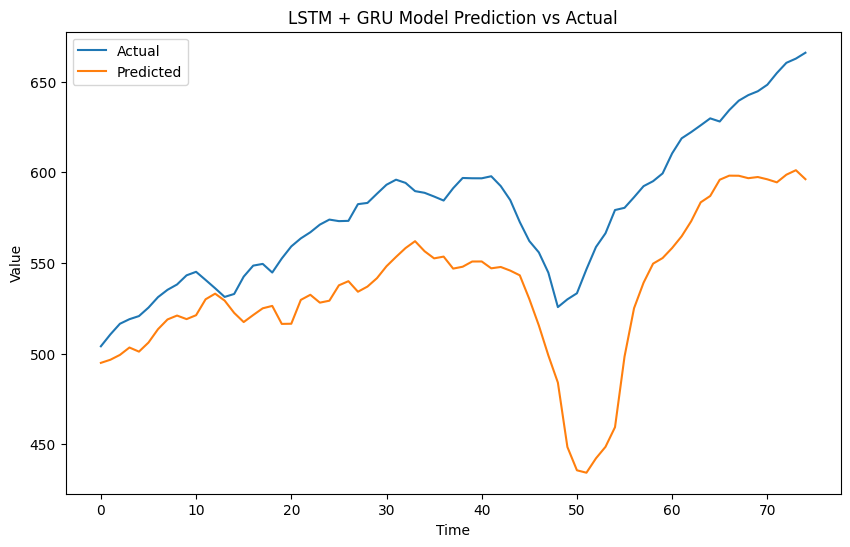

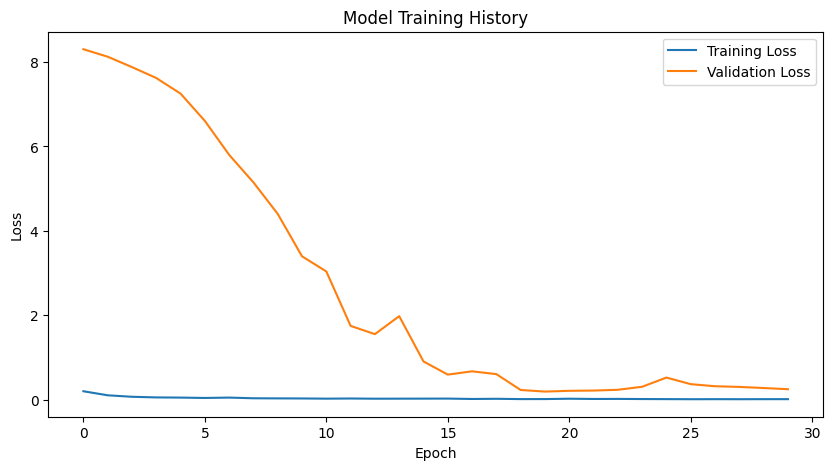

Model Performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 334732.5938 - mae: 577.1939 
Test Loss: [334732.59375, 577.1939086914062]
R²: -0.534, RMSE: 49.32828


In [117]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization

lstm_data['adj close'] = state_means
vals = lstm_data.values

n_steps = 6 # Best at 25 so far
X, y = [], []
for i in range(n_steps, len(vals)):
    X.append(vals[i - n_steps:i, :])
    y.append(vals[i, 0])

X, y = np.array(X), np.array(y)

split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize scalers
scalers = {}
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

for i in range(X.shape[2]):
    scalers[i] = MinMaxScaler()
    
    # Flatten to 2D: (samples * timesteps, 1)
    train_feat = X_train[:, :, i].reshape(-1, 1)
    test_feat = X_test[:, :, i].reshape(-1, 1)
    
    # Fit only on train
    scalers[i].fit(train_feat)
    
    # Transform and reshape back
    X_train_scaled[:, :, i] = scalers[i].transform(train_feat).reshape(X_train.shape[0], X_train.shape[1])
    X_test_scaled[:, :, i] = scalers[i].transform(test_feat).reshape(X_test.shape[0], X_test.shape[1])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()


"""
model = Sequential()
model.add(LSTM(units=41,                # best units = 41
                return_sequences=True,
                input_shape=(n_steps, X.shape[2]),
                activation='tanh',
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
           #     dropout=0.01,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                use_cudnn="auto"))

model.add(LSTM(units=41,               # best units = 41
                return_sequences=True,
                activation='tanh',
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
              #  dropout=0.01,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                use_cudnn="auto"))

model.add(GRU(units=58,
              return_sequences=False,
              activation="tanh",
              recurrent_activation="sigmoid",
              use_bias=True,
              kernel_initializer="glorot_uniform",
              recurrent_initializer="orthogonal",
              bias_initializer="zeros",
              kernel_regularizer=None,
              recurrent_regularizer=None,
              bias_regularizer=None,
              activity_regularizer=None,
              kernel_constraint=None,
              recurrent_constraint=None,
              bias_constraint=None,
              dropout=0.0,
              recurrent_dropout=0.0,
              seed=None,
              return_state=False,
              go_backwards=False,
              stateful=False,
              unroll=False,
              reset_after=True,
              use_cudnn="auto")) # best units = 58

model.add(Dense(units=1,
                activation='linear'))


model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mean_squared_error') # lr = 0.0005181785280568014
"""


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, X.shape[2])),
    BatchNormalization(),
 #   Dropout(0.2),

    LSTM(64, return_sequences=True),
  #  Dropout(0.2),

    GRU(64, return_sequences=False),
    BatchNormalization(),
   # Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_scaled,
                    y_train_scaled,
                    epochs=50,
                    batch_size=16,  # Optimal Batch Size = 16
                    validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=callbacks,
                    verbose=1)


predictions = model.predict(X_test_scaled)

predictions = y_scaler.inverse_transform(predictions)
y_test_original =y_scaler.inverse_transform(y_test_scaled.reshape(-1,1))


plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM + GRU Model Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test_original, predictions)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print("Model Performance:")
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"R²: {r2:.3f}, RMSE: {rmse:.5f}")


Feature Importance

In [113]:
corr = lstm_data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
lstm_data = lstm_data.drop(columns=to_drop)

In [118]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance_lstm(model, X, y, metric=mean_squared_error):
    """
    Compute permutation feature importance for a trained LSTM/GRU model.
    """
    base_pred = model.predict(X)
    base_score = metric(y, base_pred)
    
    importances = {}
    
    for feature_idx in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, feature_idx])  # shuffle across all timesteps
        
        perm_pred = model.predict(X_permuted)
        perm_score = metric(y, perm_pred)
        
        importances[feature_idx] = perm_score - base_score
    
    # Normalize: higher = more important
    sorted_imp = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    return sorted_imp

feature_importances = permutation_importance_lstm(model, X_test_scaled, y_test_scaled)

for idx, imp in feature_importances:
    print(f"{lstm_data.columns[idx]}: ΔMSE = {imp:.5f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
adj close: ΔMSE = 0.14183
rsi: ΔMSE = 0.03302
atr: ΔMSE = 0.02068
macd: ΔMSE = 0.01958
return_12m: ΔMSE = 0.01637
return_2m: ΔMSE = 0.00918
return_9m: ΔMSE = 0.00754
CMA: ΔMSE = 0.00031
Mkt-RF: ΔMSE = 0.00010
HML: ΔMSE = 0.00009
SMB: ΔMSE = -0.00001
garman_klass_vol: ΔMSE = -0.00027
vix: ΔMSE = -0.00140
return_1m: 

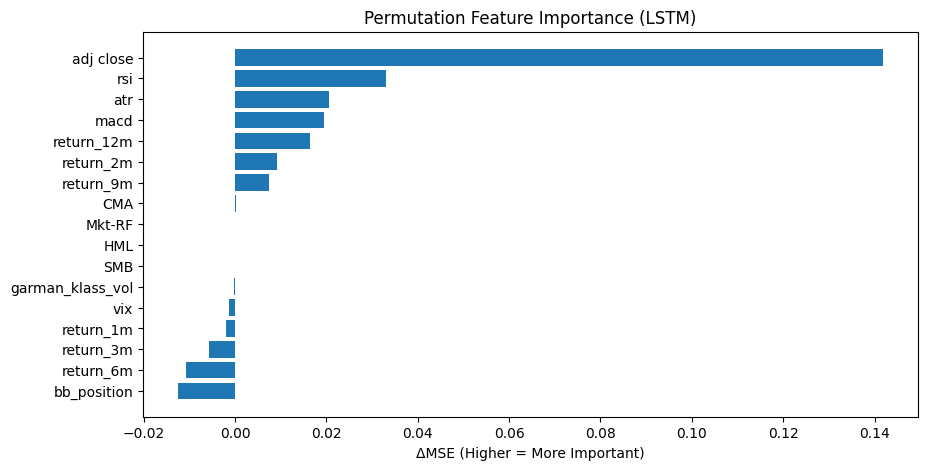

In [119]:
import matplotlib.pyplot as plt

labels = [lstm_data.columns[i] for i, _ in feature_importances]
scores = [imp for _, imp in feature_importances]

plt.figure(figsize=(10,5))
plt.barh(labels[::-1], scores[::-1])
plt.xlabel('ΔMSE (Higher = More Important)')
plt.title('Permutation Feature Importance (LSTM)')
plt.show()


In [120]:
# Keep only top N features
top_features = [lstm_data.columns[i] for i, imp in feature_importances if imp > 0.0005]
top_features

['adj close', 'rsi', 'atr', 'macd', 'return_12m', 'return_2m', 'return_9m']

In [121]:
lstm_data_filtered = lstm_data[top_features]
lstm_data_filtered

,adj close,rsi,atr,macd,return_12m,return_2m,return_9m
date,,,,,,,
2011-05-01,104.686923,65.290660,1.275400,0.887812,0.003657,0.016488,0.003879
2011-05-08,103.797357,54.980136,1.377969,0.694481,0.001041,0.001569,0.001925
2011-05-15,103.291849,52.552203,1.474862,0.518640,0.000057,-0.008798,0.003171
2011-05-22,102.788235,50.682666,1.437668,0.218302,0.001164,-0.002201,0.004987
2011-05-29,102.114238,50.996689,1.416602,-0.115306,0.001013,-0.001979,0.001856
...,...,...,...,...,...,...,...
2025-09-07,648.314611,59.890744,5.650035,4.290249,0.007004,0.001494,0.003832
2025-09-14,654.768863,65.975386,5.071020,5.461879,0.008449,0.009535,0.005880
2025-09-21,660.399570,69.622999,4.974871,6.778890,0.006615,0.014038,0.006547


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3094 - mae: 0.3940 - val_loss: 8.7069 - val_mae: 2.9296 - learning_rate: 5.0000e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0837 - mae: 0.2238 - val_loss: 8.7651 - val_mae: 2.9397 - learning_rate: 5.0000e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0667 - mae: 0.2079 - val_loss: 8.5662 - val_mae: 2.9063 - learning_rate: 5.0000e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0768 - mae: 0.2176 - val_loss: 8.4405 - val_mae: 2.8852 - learning_rate: 5.0000e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0716 - mae: 0.2084 - val_loss: 8.2093 - val_mae: 2.8459 - learning_rate: 5.0000e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454 - mae: 0.1595 - val_loss: 7.7507 - val_mae: 2.7655 - learning_rate: 5.0000e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435 - mae: 0.1605 - val_loss: 7.0588 - val_mae: 2.6384 - learning_rate: 5.

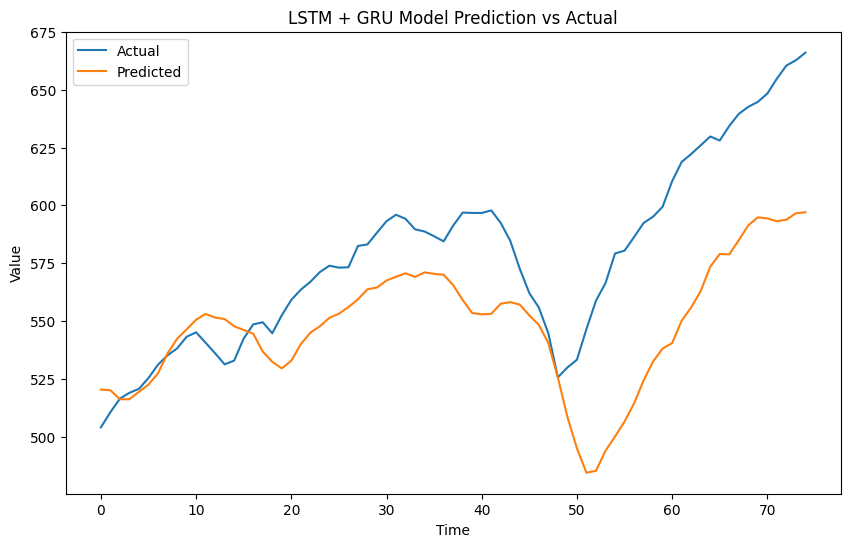

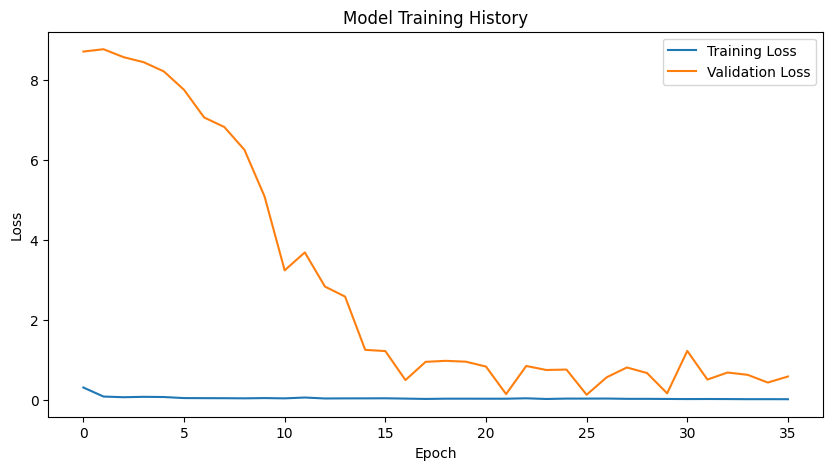

Model Performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 335827.4062 - mae: 578.1346 
Test Loss: [335827.40625, 578.1345825195312]
R²: -0.019, RMSE: 40.19961


In [122]:
vals = lstm_data_filtered.values

n_steps = 6 # Best at 25 so far
X, y = [], []
for i in range(n_steps, len(vals)):
    X.append(vals[i - n_steps:i, :])
    y.append(vals[i, 0])

X, y = np.array(X), np.array(y)

split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize scalers
scalers = {}
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

for i in range(X.shape[2]):
    scalers[i] = MinMaxScaler()
    
    # Flatten to 2D: (samples * timesteps, 1)
    train_feat = X_train[:, :, i].reshape(-1, 1)
    test_feat = X_test[:, :, i].reshape(-1, 1)
    
    # Fit only on train
    scalers[i].fit(train_feat)
    
    # Transform and reshape back
    X_train_scaled[:, :, i] = scalers[i].transform(train_feat).reshape(X_train.shape[0], X_train.shape[1])
    X_test_scaled[:, :, i] = scalers[i].transform(test_feat).reshape(X_test.shape[0], X_test.shape[1])

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, X.shape[2])),
    BatchNormalization(),
  #  Dropout(0.2),

    LSTM(64, return_sequences=True),
#    Dropout(0.2),

    GRU(64, return_sequences=False),
    BatchNormalization(),
#    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(X_train_scaled,
                    y_train_scaled,
                    epochs=50,
                    batch_size=16,  # Optimal Batch Size = 16
                    validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=callbacks,
                    verbose=1)


predictions = model.predict(X_test_scaled)

predictions = y_scaler.inverse_transform(predictions)
y_test_original =y_scaler.inverse_transform(y_test_scaled.reshape(-1,1))


plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM + GRU Model Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test_original, predictions)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print("Model Performance:")
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"R²: {r2:.3f}, RMSE: {rmse:.5f}")
